<a href="https://colab.research.google.com/github/dhruvmhjn/stat_sig/blob/main/Statsig_Workshop_P%26G_B2B_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import uuid
import random
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import binom
from scipy.stats import ttest_ind_from_stats, ttest_ind

In [ ]:
class DataSets:
  _cache = {}

  @classmethod
  @property
  # Dataset with a segmented b2b a-a test for evaluating stratification
  # efficacy
  def b2b_aa(self):
    return self.get_dataset('b2b')

  @classmethod
  def get_dataset(self, dataset_name):
    if dataset_name not in self._cache:
      print(f"Downloading {dataset_name}...")
      self._cache[dataset_name] = pd.read_csv(self.dataset_url(dataset_name))
    else:
      print(f"Using cached values for {dataset_name}...")
    return self._cache[dataset_name]

  @classmethod
  def dataset_url(self, dataset_name):
    urls = {
        'revenue': 'https://drive.google.com/uc?id=11T2oNtRipN_en-En3ao0GX0gq3T8gFCT',
        'outliers': 'https://drive.google.com/uc?id=1Kc1hFsDYU1G_TXdSVOexaFR05Ai0lMqg',
        'b2b': 'https://drive.google.com/uc?id=1-ZCudCEocyQkKZMMKkKYXJ35fHCfmElS',
    }
    return urls[dataset_name]



# Basic Test

In [ ]:
df = DataSets.b2b_aa

for column in list(df.columns):
  print("-", column)

- Unnamed: 0
- company_id
- group
- segment
- days_exposed
- revenue


## Results

In [ ]:
results = ttest_ind(
  df[df['group'] == 'test']['revenue'],
  df[df['group'] == 'control']['revenue']
)

alpha = 0.05

print(f"""
  p-value: {results.pvalue:.4g}
  conclusion: {"Reject Ho" if results.pvalue < alpha else "Fail to reject Ho"} with a p-value of {round(results.pvalue, 3)} at significance = {alpha}
""")


  p-value: 0.04918
  conclusion: Reject Ho with a p-value of 0.049 at significance = 0.05



In [ ]:
print("Is this assignation dataset problematic?\n\n")
df.groupby(['group', 'segment']).agg(
    records=('revenue', 'count'),
    total_revenue=('revenue', 'sum'),
    avg_revenue=('revenue', 'mean')
).reset_index()

Is this assignation dataset problematic?




,group,segment,records,total_revenue,avg_revenue
0,control,HEAD,1,9.438915e+05,9.438915e+05
1,control,TAIL,212,2.145098e+06,1.011839e+04
2,control,TORSO,37,3.713347e+06,1.003607e+05
3,test,HEAD,5,6.623456e+06,1.324691e+06
4,test,TAIL,205,2.211951e+06,1.079000e+04
5,test,TORSO,40,4.249317e+06,1.062329e+05


In [ ]:
print("This data was an AA test - group selection has no bearing on data output.")
print("The result was driven by an imbalance of assignments in the head segment.")
print("This fairly extreme result isn't all that rare!")

n = 6
p = 0.5

probability_1 = 1 - binom.cdf(5, n, p)
probability_2 = binom.cdf(0, n, p)
overall = probability_1 + probability_2

print(f"""
  Probability of test getting this extreme of an imbalance: {probability_1:.4g}
  Probability of control getting this extreme of an imbalance: {probability_2:.4g}
  Probability of either getting this extreme of an imbalance: {overall:.4g}
""")

This data was an AA test - group selection has no bearing on data output.
The result was driven by an imbalance of assignments in the head segment.
This fairly extreme result isn't all that rare!

  Probability of test getting this extreme of an imbalance: 0.01562
  Probability of control getting this extreme of an imbalance: 0.01562
  Probability of either getting this extreme of an imbalance: 0.03125



## A/A Testing

AA Testing is running a test with no intervention to make sure you don't get false positives more than expected
This can be done at the assignment level to make sure there's not issues with the assignment service,
or on analysis to evaluate the stats engine. For the latter, we can just shuffle assignments


5.3% of results were statistically significant false positives




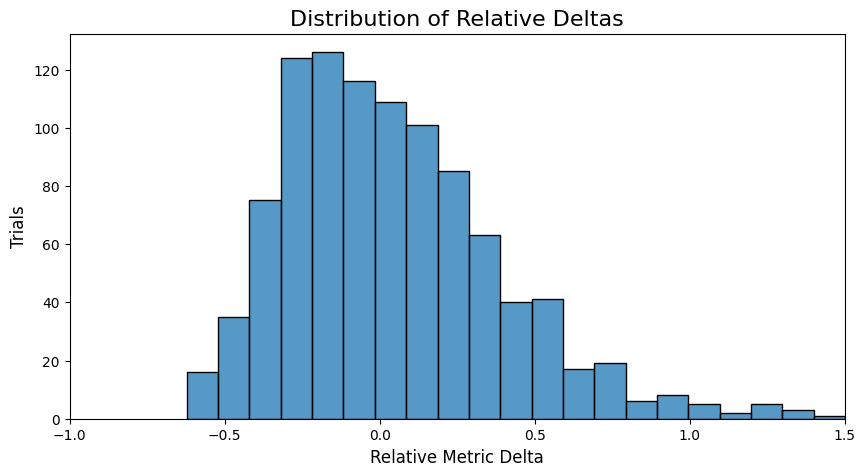

In [ ]:
print("AA Testing is running a test with no intervention to make sure you "+\
      "don't get false positives more than expected")
print("This can be done at the assignment level to make sure there's not "+\
      "issues with the assignment service,\nor on analysis to evaluate the "+\
      "stats engine. For the latter, we can just shuffle assignments\n\n")

trials = 1000
df_s = df.copy()

deltas = []
p_values = []

for i in range(trials):
  salt = str(uuid.uuid4())
  df_s['group'] = df_s['company_id']\
    .apply(lambda x: 'test' if abs(hash(salt + x)) % 2 == 0 else 'control')

  rt = df_s[df_s['group'] == 'test']['revenue']
  rc = df_s[df_s['group'] == 'control']['revenue']

  deltas.append((np.mean(rt) - np.mean(rc)) / np.mean(rc))
  p_values.append(ttest_ind(rt, rc).pvalue)

print(f"{100*len([p for p in p_values if p < 0.05])/len(p_values)}% of results were statistically significant false positives\n\n")

plt.figure(figsize=(10, 5))
sns.histplot(deltas, binwidth=0.1)
plt.title("Distribution of Relative Deltas", fontsize=16)
plt.xlabel("Relative Metric Delta", fontsize=12)
plt.ylabel("Trials", fontsize=12)
plt.xlim(-1, 1.5)
plt.show()


Salt selection is a halfway form of stratified sampling that selects salts with good properties
0.0% of results were statistically significant false positives




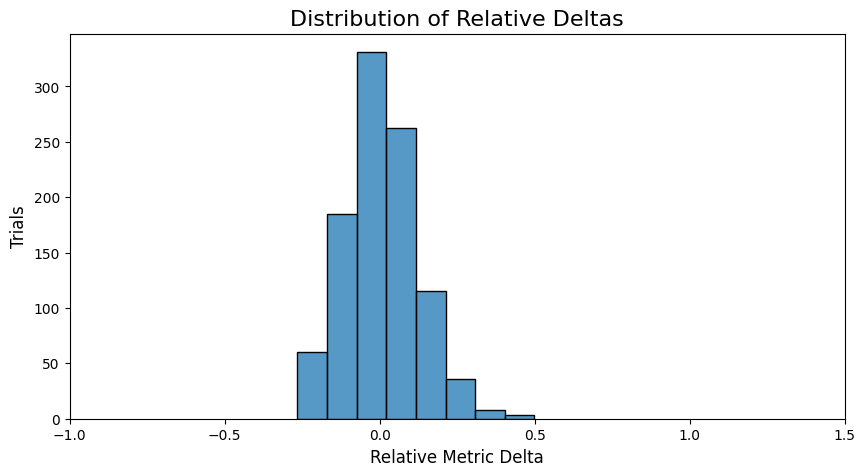

In [ ]:
print("Salt selection is a halfway form of stratified sampling that selects "+\
  "salts with good properties")

trials = 1000
df_s = df.copy()

deltas = []
p_values = []

totals = {
    'HEAD': df[df['segment'] == 'HEAD'].shape[0],
    'TORSO': df[df['segment'] == 'TORSO'].shape[0],
    'TAIL': df[df['segment'] == 'TAIL'].shape[0],
}

# In practice we select the best salt out of N using the modified chi-sq approach
# above. To demo the efficacy in a short runtime, since we
# can't parallelize well, we're just doing a hacky version where we
# make sure the head-segment distribution is balanced
# quasi code for the real approach is included, but commented out
salt_threshold = 0.005
def is_salt_balanced(df_s):
  # total_score = 0
  # for segment in ['HEAD', 'TAIL', 'TORSO']:
    # test_ct = df_s[(df_s['group'] == 'test') & (df_s['segment'] == segment)].shape[0]
    # partial_chi = (test_ct - (totals[segment]/2))**2 / totals[segment] +\
    #   (totals[segment]/2 - test_ct)**2 / totals[segment]
    # scaled_partial = partial_chi / math.sqrt(totals[segment])
    # total_score += scaled_partial

  return df_s[(df_s['group'] == 'test') & (df_s['segment'] == 'HEAD')].shape[0]\
     in [math.floor(totals['HEAD']/2), math.ceil(totals['HEAD']/2)]


for i in range(trials):
  salt_imbalanced = True
  while salt_imbalanced:
    salt = str(uuid.uuid4())
    df_s['group'] = df_s['company_id']\
      .apply(lambda x: 'test' if abs(hash(salt + x)) % 2 == 0 else 'control')
    salt_imbalanced = not is_salt_balanced(df_s)

  rt = df_s[df_s['group'] == 'test']['revenue']
  rc = df_s[df_s['group'] == 'control']['revenue']

  deltas.append((np.mean(rt) - np.mean(rc)) / np.mean(rc))
  p_values.append(ttest_ind(rt, rc).pvalue)

print(f"{100*len([p for p in p_values if p < 0.05])/len(p_values)}% of results were statistically significant false positives\n\n")

plt.figure(figsize=(10, 5))
sns.histplot(deltas, binwidth=0.1)
plt.title("Distribution of Relative Deltas", fontsize=16)
plt.xlabel("Relative Metric Delta", fontsize=12)
plt.ylabel("Trials", fontsize=12)
plt.xlim(-1, 1.5)
plt.show()


In [ ]:
print("For discussion - what risks come with this approach?\n")
print("What is this approach acheiving in practice?")
print(" - Reducing variance?")
print(" - Reducing false discovery rate?")
print(" - Increasing effective power?")

For discussion - what risks come with this approach?

What is this approach acheiving in practice?
 - Reducing variance?
 - Reducing false discovery rate?
 - Increasing effective power?
